# In-Processing Mitigation

##  Logistic Regression

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

In [106]:
df = pd.read_csv('complete_df_with_predictions.csv')

In [107]:
# Features we want to use
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white']

# Target variable
target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

### Fairness Constrain on fam_inc 

We will first try with **Fairness Constrained** on Logistic Regression, intervening directly on the loss function introducing 
Demographic Parity, Equal Opportunity, Equalized Odds.

In [108]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 5, 1: 1}),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['fam_inc'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [109]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 184   43]
 [2738 1450]]
              precision    recall  f1-score   support

           0       0.06      0.81      0.12       227
           1       0.97      0.35      0.51      4188

    accuracy                           0.37      4415
   macro avg       0.52      0.58      0.31      4415
weighted avg       0.92      0.37      0.49      4415



In [110]:
pass_bar_lr_weighted_fair_fam_inc = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_fam_inc'] = pass_bar_lr_weighted_fair_fam_inc

In [111]:
from scipy.stats import wasserstein_distance


def get_DI_SPD_WD(groups, df, feature_name, ref_val, pred_col):
    
    results = {}
    
    for group in groups:
        df_temp = df[df[feature_name].isin([ref_val, group])].copy()
        df_temp[f"{feature_name}_bin"] = df_temp[feature_name].apply(lambda x: 1 if x == ref_val else 0)
        df_numeric = df_temp.select_dtypes(include=[np.number])
        
        for col in [pred_col, f"{feature_name}_bin"]:
            if col not in df_numeric.columns:
                df_numeric[col] = df_temp[col]

        df_numeric = df_numeric.dropna(subset=[pred_col, f"{feature_name}_bin"])

        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df_numeric,
            label_names=[pred_col],
            protected_attribute_names=[f"{feature_name}_bin"]
        )

        metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{f"{feature_name}_bin": 1}],  
        unprivileged_groups=[{f"{feature_name}_bin": 0}] 
        )
        
        # Wasserstein Distance
        group_0_preds = df_numeric[df_numeric[f"{feature_name}_bin"] == 0][pred_col]
        group_1_preds = df_numeric[df_numeric[f"{feature_name}_bin"] == 1][pred_col]
        wd = wasserstein_distance(group_0_preds, group_1_preds)
        
        results[group] = {
        "Disparate Impact": metric.disparate_impact(),
        "Statistical Parity Difference": metric.statistical_parity_difference(),
        "Wasserstein Distance": wd
        }
        
    return results

def plot_fairness_metrics(results, col_name, refer_class):
    results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': col_name})
    results_df = results_df.sort_values(by=col_name)

    metrics = ["Disparate Impact", "Statistical Parity Difference", "Wasserstein Distance"]
    titles = [
        f"Disparate Impact (Compared to {refer_class})",
        f"Statistical Parity Difference (Compared to {refer_class})",
        f"Wasserstein Distance (Compared to {refer_class})"
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, metric in enumerate(metrics):
        sns.barplot(data=results_df, x=col_name, y=metric, hue=col_name, palette='crest', dodge=False, legend=False, ax=axes[i])
        
        # Add reference lines and fixed y-axis limits
        if metric == "Disparate Impact":
            axes[i].axhline(1.0, linestyle='--', color='black')
        elif metric == "Statistical Parity Difference":
            axes[i].axhline(0.0, linestyle='--', color='black')
            axes[i].set_ylim(-0.2, 0.2)  # Fixed y-axis for SPD
        elif metric == "Wasserstein Distance":
            axes[i].set_ylim(0, 0.1)  # Fixed y-axis for WD

        axes[i].set_title(titles[i])
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel(col_name)

        # Add bar value annotations
        for idx, row in results_df.iterrows():
            value = row[metric]
            offset = 0.01 if value >= 0 else -0.05
            axes[i].text(idx, value + offset, f"{value:.2f}", ha='center',
                         va='bottom' if value >= 0 else 'top')

    plt.tight_layout()
    plt.show()

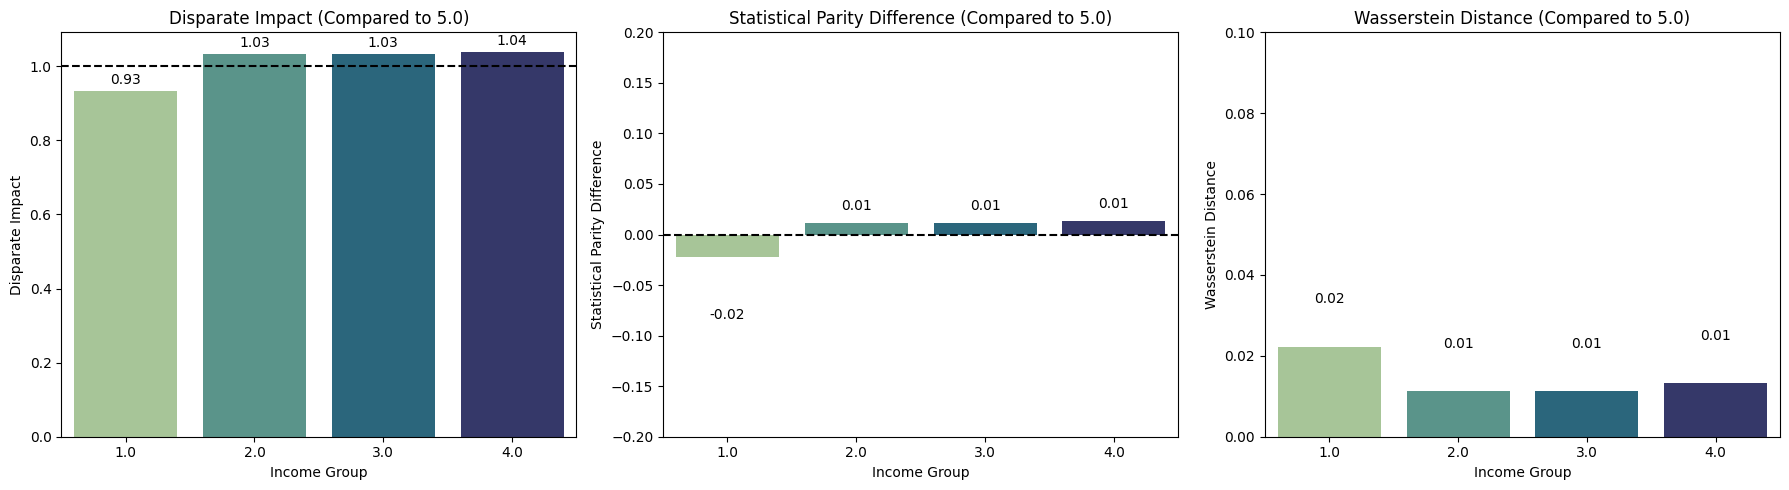

In [112]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_lr_weighted_fair_fam_inc')
plot_fairness_metrics(results, 'Income Group', 5.0)

### Fairness Constrain on Tier

In [113]:
mitigator = ExponentiatedGradient(
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 5, 1: 1}),
    constraints=DemographicParity()
)

#mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
y_pred = mitigator.predict(X_test)

In [114]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  97  130]
 [ 259 3929]]
              precision    recall  f1-score   support

           0       0.27      0.43      0.33       227
           1       0.97      0.94      0.95      4188

    accuracy                           0.91      4415
   macro avg       0.62      0.68      0.64      4415
weighted avg       0.93      0.91      0.92      4415



It seems that forcing parity over the tier feasture introduces some unabalancing in the model. But let's see if the we managed to remove the bias.

In [115]:
pass_bar_lr_weighted_fair_tier = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_tier'] = pass_bar_lr_weighted_fair_tier

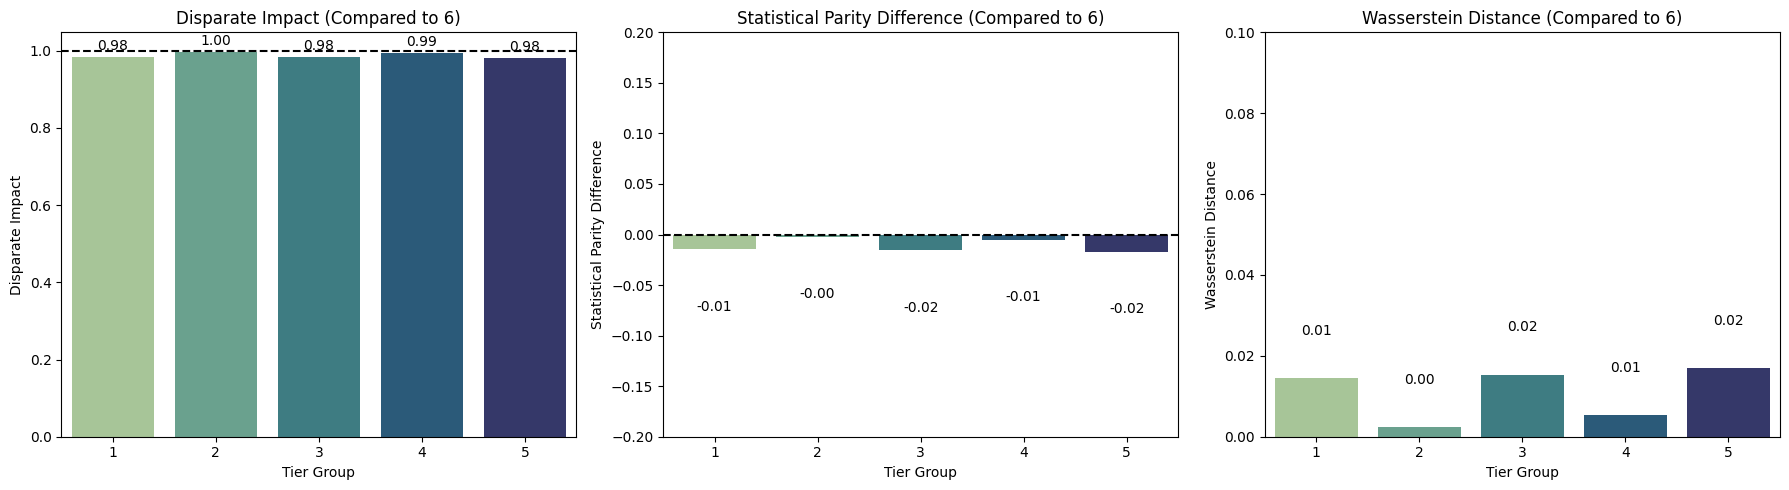

In [116]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_lr_weighted_fair_tier')
plot_fairness_metrics(results, 'Tier Group', 6)

### Fairness Constrain on Race

In [117]:
features_race1 = features.copy()
features_race1.append('race1')
#X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(df[features_race1], df[target], test_size=0.2, random_state=42)

In [118]:
sensitive_race_train = df.loc[X_train.index, 'race1']

In [119]:
mitigator = ExponentiatedGradient(
    LogisticRegression(max_iter=1000, C=1, class_weight={0: 5, 1: 1}),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_race_train)
y_pred = mitigator.predict(X_test)

In [120]:
pass_bar_lr_weighted_fair_race = mitigator.predict(df[features])
df['pass_bar_lr_weighted_fair_race'] = pass_bar_lr_weighted_fair_race

In [121]:
print(df['race1'].unique())

['white' 'hisp' 'asian' 'black' 'other']


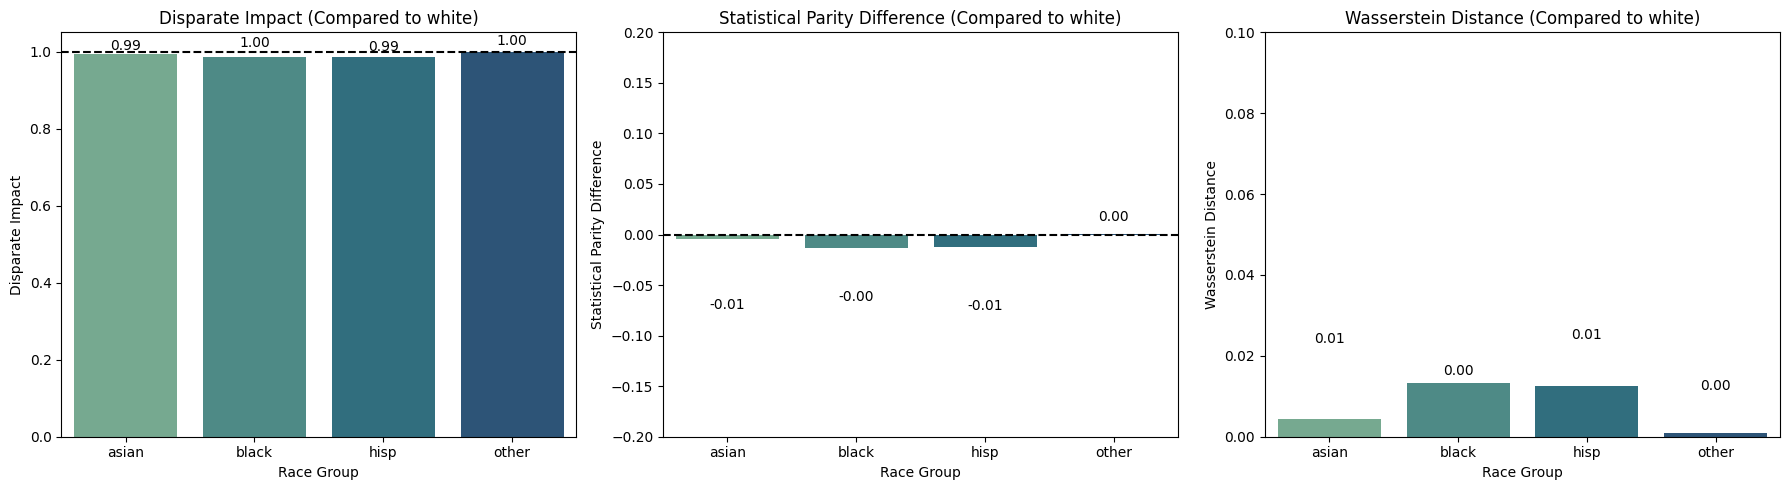

In [122]:
race_groups = ['hisp', 'asian', 'black', 'other']
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_lr_weighted_fair_race')
plot_fairness_metrics(results, 'Race Group', 'white')

## Random Forest

In [123]:
from sklearn.ensemble import RandomForestClassifier

### Fairness Constrain on Family Income

In [124]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['fam_inc'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [125]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 155   72]
 [ 677 3511]]
              precision    recall  f1-score   support

           0       0.19      0.68      0.29       227
           1       0.98      0.84      0.90      4188

    accuracy                           0.83      4415
   macro avg       0.58      0.76      0.60      4415
weighted avg       0.94      0.83      0.87      4415



In [126]:
pass_bar_rf_fair_fam_inc = mitigator.predict(df[features])
df['pass_bar_rf_fair_fam_inc'] = pass_bar_rf_fair_fam_inc

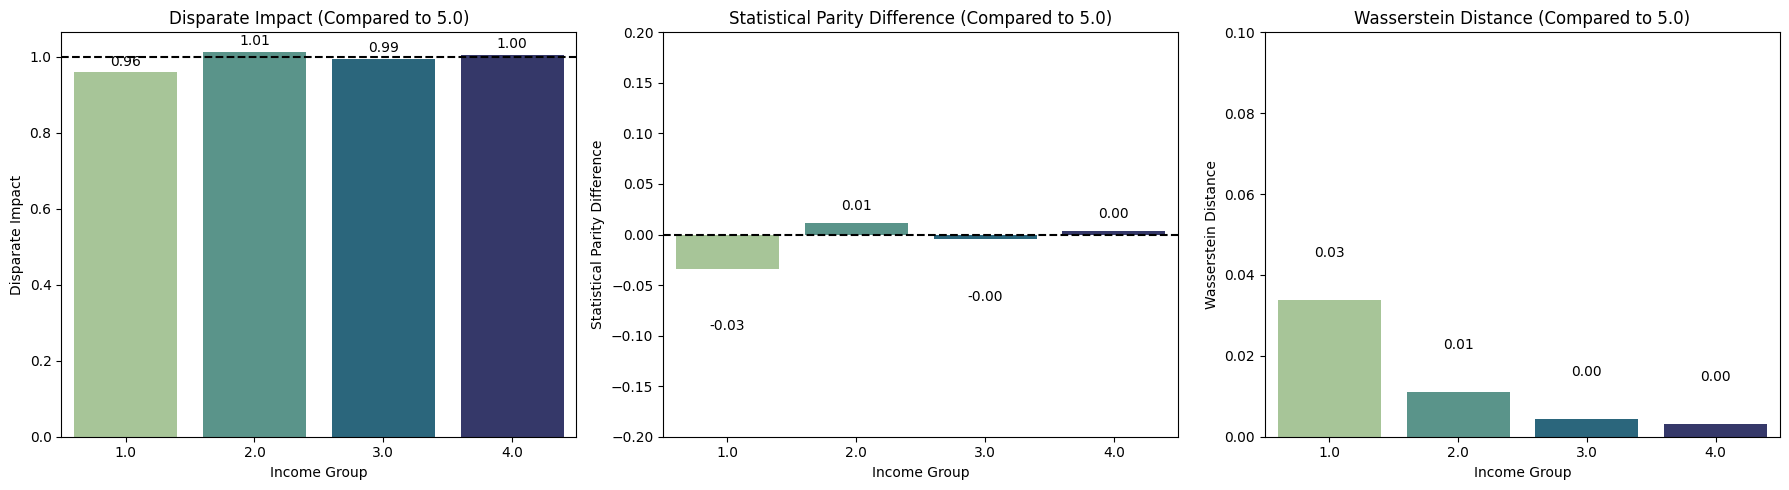

In [127]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_rf_fair_fam_inc')
plot_fairness_metrics(results, 'Income Group', 5.0)

### Fairness Constrain on Tier

In [128]:
mitigator = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

#mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])
y_pred = mitigator.predict(X_test)

In [129]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 137   90]
 [ 647 3541]]
              precision    recall  f1-score   support

           0       0.17      0.60      0.27       227
           1       0.98      0.85      0.91      4188

    accuracy                           0.83      4415
   macro avg       0.57      0.72      0.59      4415
weighted avg       0.93      0.83      0.87      4415



In [130]:
pass_bar_rf_fair_tier = mitigator.predict(df[features])
df['pass_bar_rf_fair_tier'] = pass_bar_rf_fair_tier

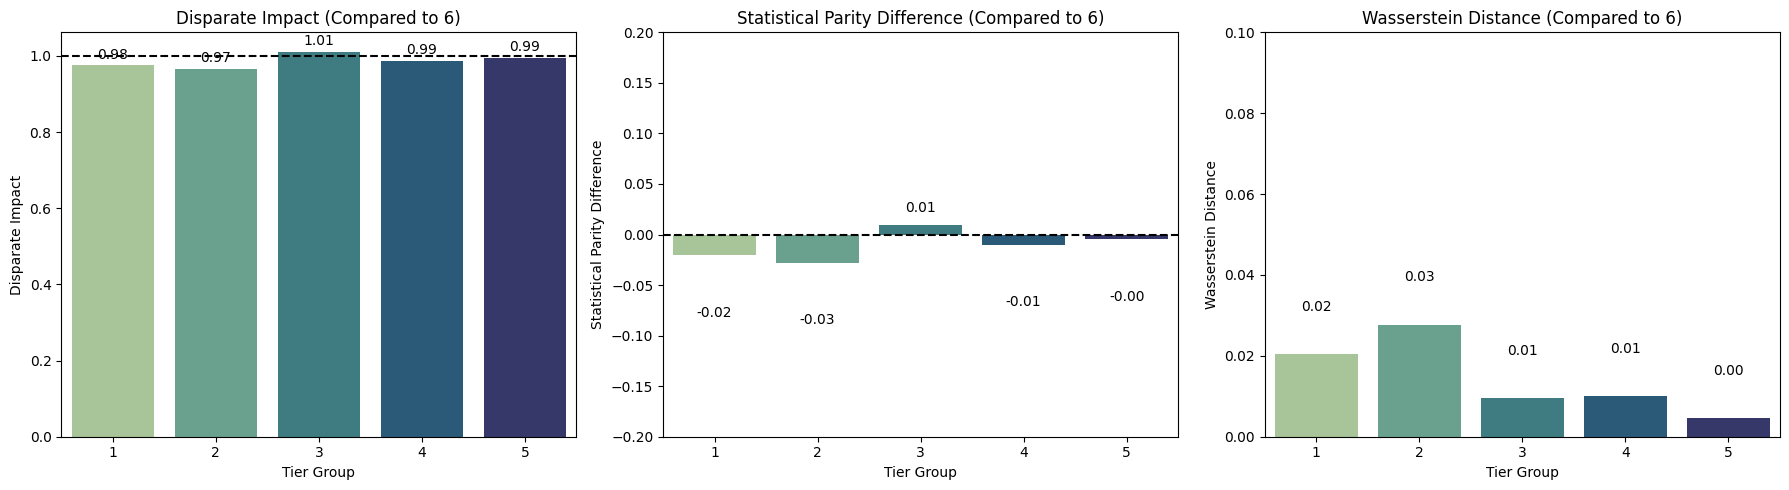

In [131]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_rf_fair_tier')
plot_fairness_metrics(results, 'Tier Group', 6)

### Fairness Constrain on Race

In [132]:
mitigator = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2, max_depth=8, min_samples_split=10),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_race_train)
y_pred = mitigator.predict(X_test)

In [133]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  78  149]
 [ 554 3634]]
              precision    recall  f1-score   support

           0       0.12      0.34      0.18       227
           1       0.96      0.87      0.91      4188

    accuracy                           0.84      4415
   macro avg       0.54      0.61      0.55      4415
weighted avg       0.92      0.84      0.87      4415



In [134]:
pass_bar_rf_fair_race = mitigator.predict(df[features])
df['pass_bar_rf_fair_race'] = pass_bar_rf_fair_race

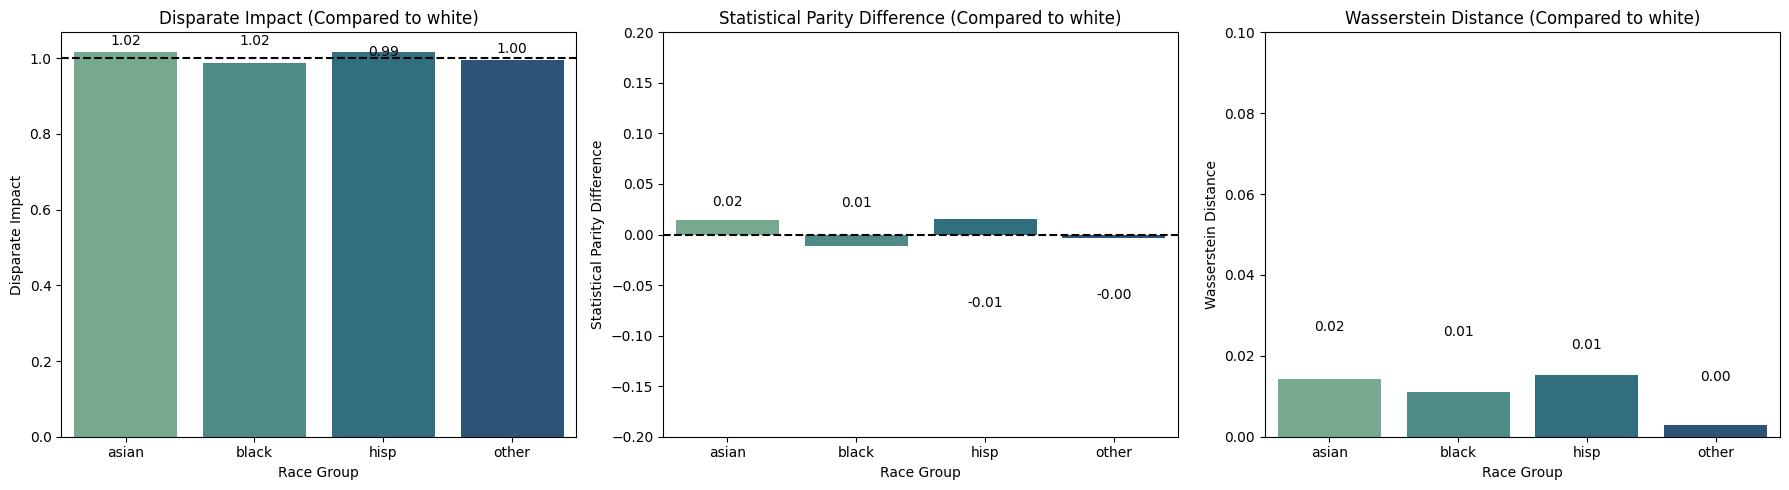

In [135]:
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_rf_fair_race')
plot_fairness_metrics(results, 'Race Group', 'white')

##  XGBoost

In [136]:
from xgboost import XGBClassifier

ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

### Fairness Constraint on fam_inc

In [137]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['fam_inc'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [138]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 158   69]
 [ 725 3463]]
              precision    recall  f1-score   support

           0       0.18      0.70      0.28       227
           1       0.98      0.83      0.90      4188

    accuracy                           0.82      4415
   macro avg       0.58      0.76      0.59      4415
weighted avg       0.94      0.82      0.87      4415



In [139]:
pass_bar_xgb_fair_fam_inc = mitigator.predict(df[features])
df['pass_bar_xgb_fair_fam_inc'] = pass_bar_xgb_fair_fam_inc

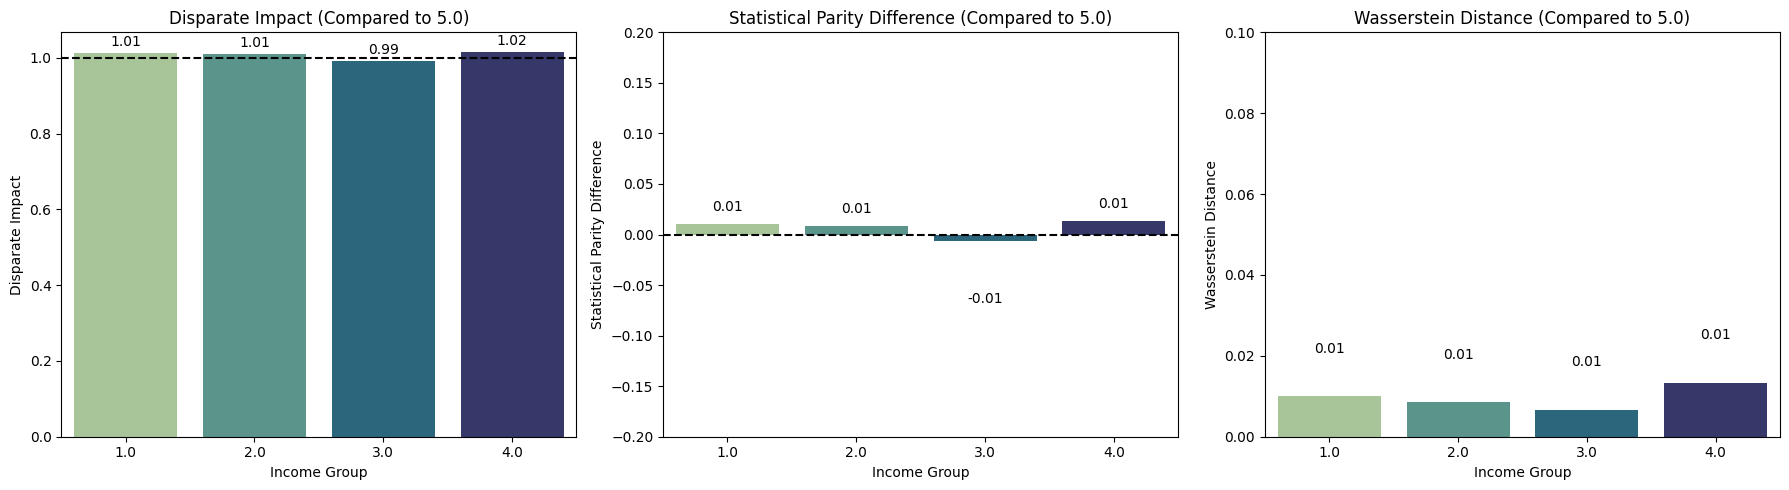

In [140]:
results = get_DI_SPD_WD(income_groups, df, 'fam_inc', 5.0, 'pass_bar_xgb_fair_fam_inc')
plot_fairness_metrics(results, 'Income Group', 5.0)

### Fairness Constraint on Tier

In [141]:
mitigator = ExponentiatedGradient(
    # Let's use the same parameters as the best model we previously trained
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

# Fit model with fairness constraint on fam_income
mitigator.fit(X_train, y_train, sensitive_features=X_train['tier'])

# Predict on test set
y_pred = mitigator.predict(X_test)

In [142]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 151   76]
 [ 692 3496]]
              precision    recall  f1-score   support

           0       0.18      0.67      0.28       227
           1       0.98      0.83      0.90      4188

    accuracy                           0.83      4415
   macro avg       0.58      0.75      0.59      4415
weighted avg       0.94      0.83      0.87      4415



In [143]:
pass_bar_xgb_fair_tier = mitigator.predict(df[features])
df['pass_bar_xgb_fair_tier'] = pass_bar_xgb_fair_tier

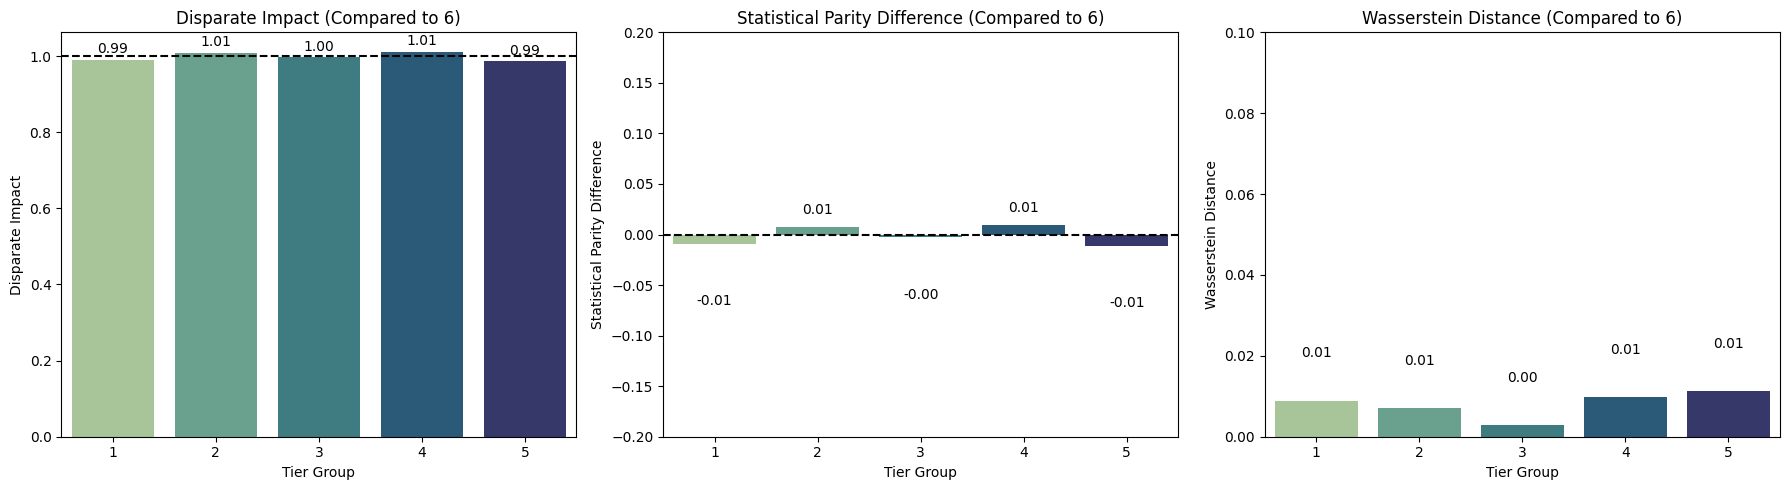

In [144]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df, 'tier', 6, 'pass_bar_xgb_fair_tier')
plot_fairness_metrics(results, 'Tier Group', 6)

### Fairness Constraint on Race

In [145]:
mitigator = ExponentiatedGradient(
    XGBClassifier(eval_metric='logloss', scale_pos_weight=ratio, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_race_train)
y_pred = mitigator.predict(X_test)

In [146]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  69  158]
 [ 457 3731]]
              precision    recall  f1-score   support

           0       0.13      0.30      0.18       227
           1       0.96      0.89      0.92      4188

    accuracy                           0.86      4415
   macro avg       0.55      0.60      0.55      4415
weighted avg       0.92      0.86      0.89      4415



In [147]:
pass_bar_xgb_fair_race = mitigator.predict(df[features])
df['pass_bar_xgb_fair_race'] = pass_bar_xgb_fair_race

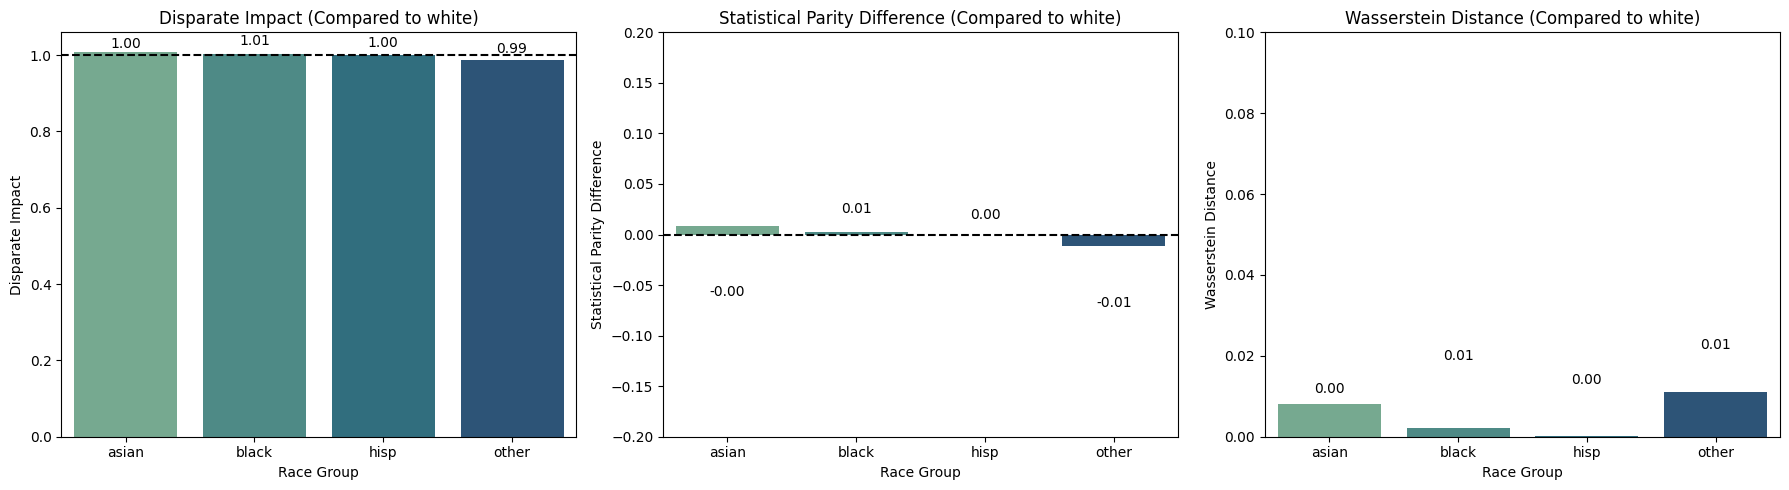

In [148]:
results = get_DI_SPD_WD(race_groups, df, 'race1', 'white', 'pass_bar_xgb_fair_race')
plot_fairness_metrics(results, 'Race Group', 'white')